# Time Series Forecasting

The _objectives_ in the following `Notebook` are:

1. Performing Time Series Modelling using <code style="background:yellow;color:black">ARIMA</code> by proper analysis and description. 
2. Look for possible insights with the help of __time series data.__
3. Perform EDA for explanation and report the observations.



__Some important points:__
- For solving this problem we will be following the steps discussed in the NB and for explaining the observation `boxes` willl be used
- Only `function` will be used with all utilities and we will try to generalise the data without splitting it into `train or test`.

In [1]:
# run the libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,median_absolute_error, mean_squared_error, mean_squared_log_error
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# read the data and see it....
df = pd.read_csv('regression_features.csv', index_col=['Date'], parse_dates=['Date'])[['StainlessSteelPrice']].sort_index()
df.head()

,StainlessSteelPrice
Date,
2013-07-01,0.827352
2013-08-01,0.760221
2013-09-01,0.784715
2013-10-01,0.769293
2013-11-01,0.750242


> Converting the __target variable__  into `log` scale for better scaling

In [3]:
## we will try to make it stationary
df['StainlessSteelPrice'] = np.log1p(df['StainlessSteelPrice'])

## EDA & Analysis

- We will perform some EDA and analysis to understand the additive component of data which can be decomposed into trend and seasonality.

- The prime concern for us to make the data stationary as __ARIMA model__ can only be applied to `stationary data.`

- We will also see the effect of the rolling average window and smoothening effect in the data.


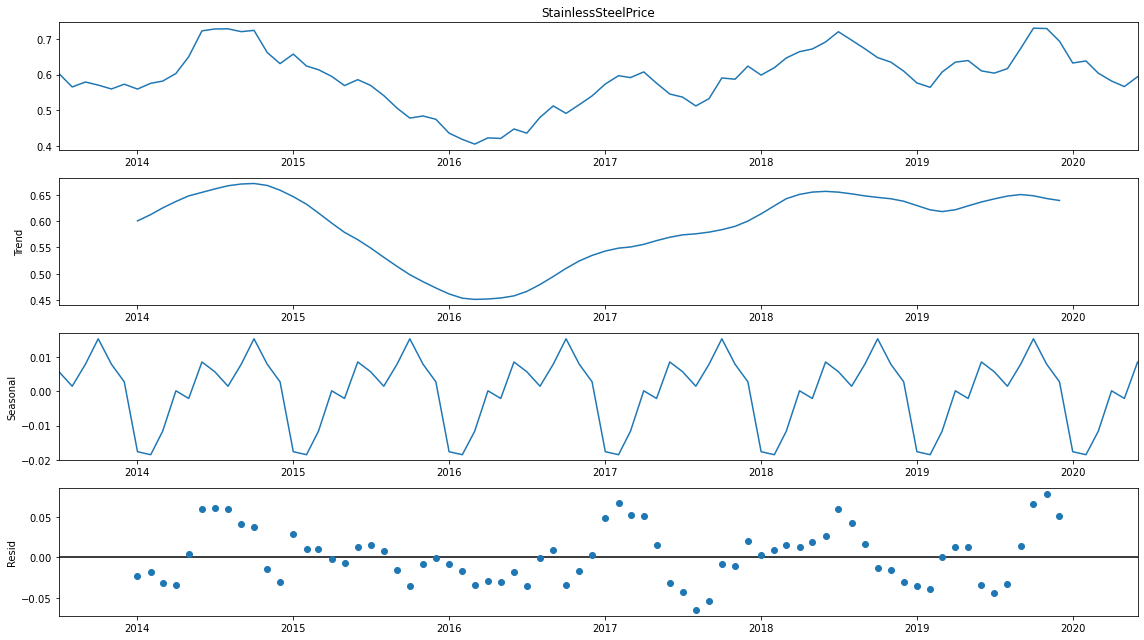

In [4]:
## Lets us decompose the data into additive components
decomposition = sm.tsa.seasonal_decompose(df.StainlessSteelPrice, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

<div class="alert alert-block alert-warning">

__Decomposition__
    
1. There is a seasonality component in the data which needs to be further verified by `Dicky-Fuller test`
    
2. The residual effect leads to a skewed distribution which needs to be properly taken care off.
    
</div>

### Moving Average

Now we will se the effect of __Moving Average__ in the smoothening of data and try to find out the trend in rolling mean in the data

In [5]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
## for ref. 2
moving_average(df,2) # prediction for the last observation interval

0.5803059455003678

In [7]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

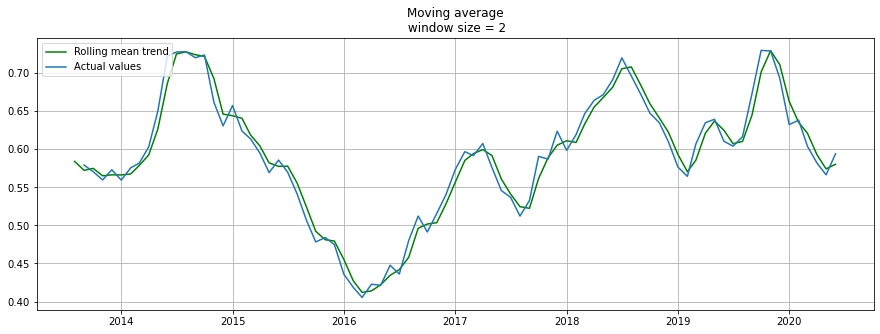

In [8]:
## lets plot moving average
plotMovingAverage(df, 2)

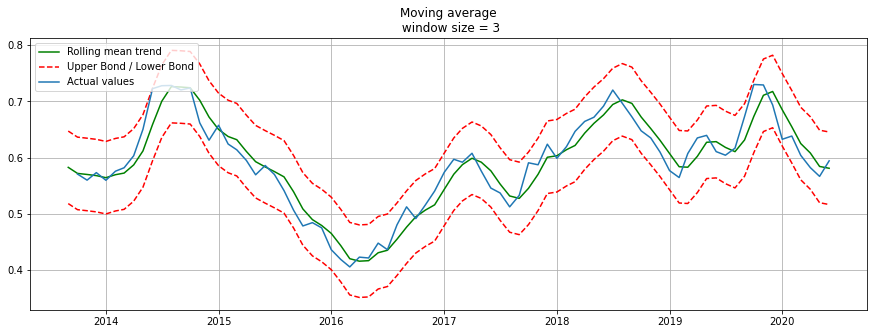

In [9]:
## lets see if any anomalies exist
plotMovingAverage(df, 3, plot_intervals=True, plot_anomalies=True)

<div class="alert alert-block alert-warning">

__Moving Average__
    
1. The rolling mean window needs to be set high for smoothening of data. The upper trend value and lower trend value also confirms it.
    
2. Due to low number of data points this cannot be done as we have restricted number of points in our data.
    
</div>

### Exponential Smoothing

Instead of weighting the last  'k'  values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$
y_t = \alpha * y_t + (1 - \alpha) * y_{t -1}
$$

In [10]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [11]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

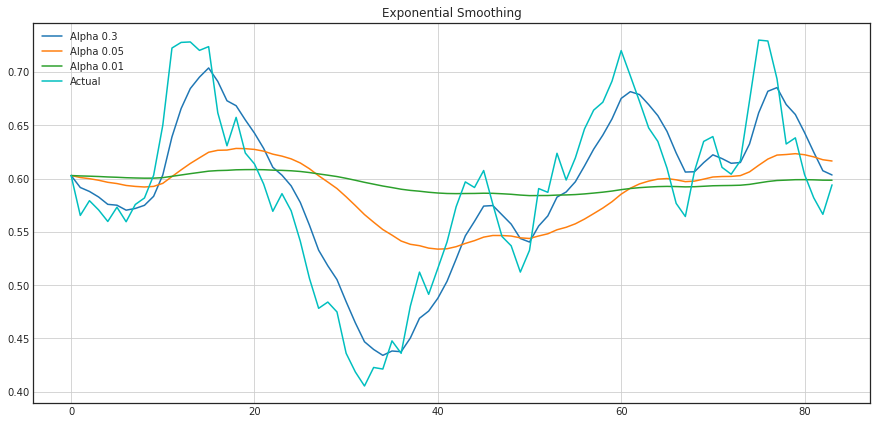

In [12]:
## let us plot with various scales of smoothing
plotExponentialSmoothing(df.StainlessSteelPrice, [0.3, 0.05, 0.01])

> We observe that with decreasing alpha values we get more flattened curve which tells us that over a period of time the steel price do have `impact` with previous values

## Time Series Modelling

Now we will move towards ARIMA model. But before doing it we need to check for __stationarity__ of our data. For doing this we will use __'Dicky-Fuller'__ test

In [13]:
### Test for stationary

def ad_test(dataset,significance=0.05):
     '''
     This function takes input as data and check for stationary
     '''
     ## let us get the test result
     dftest = adfuller(dataset, autolag = 'AIC')
        
     ## print the values
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
        
     if dftest[1] <= significance:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
     else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
def metric_calc(forecast, actual, model_name=None):
        '''
        This calculates the accuracy metrics gives our predicted and test data
        '''
        # Calculate metrics and append it
        mae  = metrics.mean_absolute_error(forecast, actual)
        mape = metrics.mean_absolute_percentage_error(forecast, actual)
        mse  = metrics.mean_squared_error(forecast, actual)
        rmse = np.sqrt(metrics.mean_squared_error(forecast, actual))
        r2   = metrics.r2_score(forecast, actual)
        
        if model_name:
            print(colored("The results of your {} are :".format(model_name),color = 'yellow', attrs=['bold']))
        # print the metrics
        print('Mean Absolute Error:', mae)
        print('Mean Absolute Percentage Error:', mape)
        print('Mean Squared Error:',  mse)
        print('Root Mean Squared Error:', rmse)
        print('R Squared:', r2)     

In [14]:
## lets check for stationarity
ad_test(df.StainlessSteelPrice)

1. ADF :  -2.232309761055082
2. P-Value :  0.19472850870353425
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 82
5. Critical Values :
	 1% :  -3.512738056978279
	 5% :  -2.8974898650628984
	 10% :  -2.585948732897085
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 




<div class="alert alert-block alert-danger">
    
<b>Stationary:</b>
Our data is non-stationary and needs to be made stationary. For this purpose we will take first order difference
    
> We can't do seasonal difference as we lack data points to do it.
    
</div>


```python
## apply smothing
df['StainlessSteelPrice'][1:] = exponential_smoothing(df['StainlessSteelPrice'][1:],0.3)
```

In [15]:
## take the difference and check for stationarity
value = np.diff(df['StainlessSteelPrice'])

## Lets do the test again
ad_test(value,significance=0.05)

1. ADF :  -6.5008640295342035
2. P-Value :  1.1627987939264921e-08
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 82
5. Critical Values :
	 1% :  -3.512738056978279
	 5% :  -2.8974898650628984
	 10% :  -2.585948732897085
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


__Some Facts__:

1. __Identification of an AR model is often best done with the PACF:__
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.


2. __Identification of an MA model is often best done with the ACF rather than the PACF:__
For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

>Since, we are trying to develop an ARIMA model we want values `p,d,q`
- p : AR Model Lags
- d : Differencing
- q : MA Model Lags

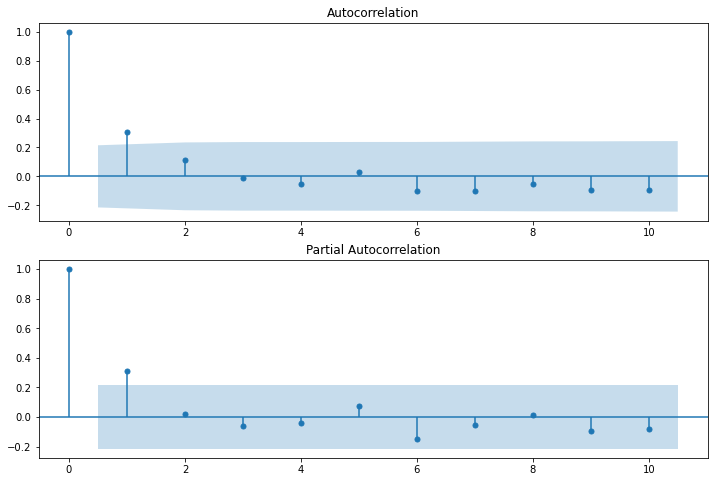

In [16]:
## plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(value,lags=10,ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(value,lags=10,ax=ax2)


> PACF shows significant coorelation at Lag 3 so our `p = 3`

> ACF shows significant value at Lag 1 so our `q = 1`

In [17]:
## ARIMA value with p = 3, d = 0, q = 3
model    =ARIMA(df['StainlessSteelPrice'],order=(3,0,1))
model_fit= model.fit()

In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     StainlessSteelPrice   No. Observations:                   84
Model:                      ARMA(3, 1)   Log Likelihood                 189.597
Method:                        css-mle   S.D. of innovations              0.025
Date:                 Wed, 02 Jun 2021   AIC                           -367.195
Time:                         02:59:01   BIC                           -352.610
Sample:                     07-01-2013   HQIC                          -361.332
                          - 06-01-2020                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.5847      0.010     57.617      0.000       0.565       0.605
ar.L1.StainlessSteelPrice     2.1862      0.108     20.180      0.000       1.974       2.399
ar.L2.StainlessSteelPrice    -1.4716      0.213     -6.896      0.000      -1.890      -1.053
ar.L3.StainlessSteelPrice     0.2765      0.109      2.527      0.011       0.062       0.491
ma.L1.StainlessSteelPrice    -0.9996      0.032    -30.863      0.000      -1.063      -0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0561           -0.1064j            1.0615           -0.0160
AR.2            1.0561           +0.1064j            1.0615            0.0160
AR.3            3.2093           -0.0000j            3.2093           -0.0000
MA.1            1.0004           +0.0000j            1.0004            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

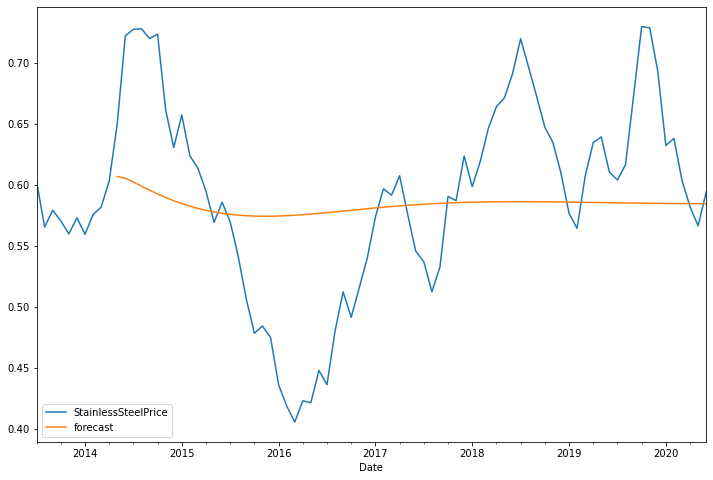

In [19]:
df['forecast']=model_fit.predict(start=10,end=85,dynamic=True)
df[['StainlessSteelPrice','forecast']].plot(figsize=(12,8))

In [20]:
## Let us calculate the metric for some of our data points
metric_calc(df['StainlessSteelPrice'][10:],df['forecast'][10:], model_name=None)

Mean Absolute Error: 0.06464948952633782
Mean Absolute Percentage Error: 0.11474170783229007
Mean Squared Error: 0.006436722254291669
Root Mean Squared Error: 0.0802291858010018
R Squared: 0.09993748978390538


<AxesSubplot:ylabel='Density'>

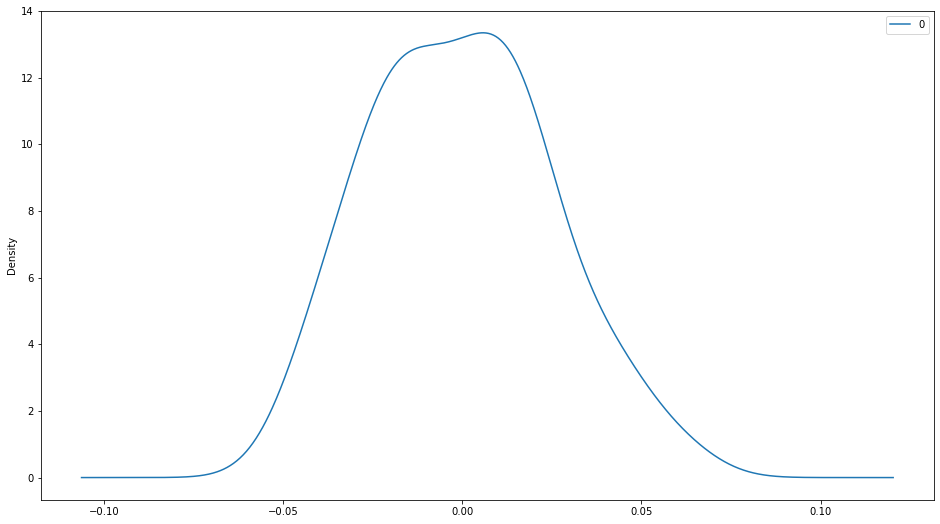

In [21]:
## plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')

<div class="alert alert-block alert-warning">

__Modelling:__
    
1. The modelling taking first order difference yields very poor results and our predicted line closely <code style="background:yellow;color:black">resembles to the mean value.</code>
    
2. However we do acheive a considerable `MAPE` value and our residuals almost __normally distributed.__  
    
</div>

__Curious With Prophet__

Let us see with Prophet what is the outcome on our total dataset...

In [22]:
## load and instantiate
from fbprophet import Prophet
m = Prophet()

In [23]:
## preparing the data into proper format for prophet
f = pd.DataFrame({"ds" : df.index, "y" : df['StainlessSteelPrice']}).reset_index(drop=True)

In [24]:
## running the prophet model
m.fit(f)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
91,2021-02-01,0.657394,0.641403,0.808427,0.655532,0.659261,0.066575,0.066575,0.066575,0.066575,0.066575,0.066575,0.0,0.0,0.0,0.723970
92,2021-03-01,0.659607,0.576989,0.741340,0.657432,0.661877,-0.004946,-0.004946,-0.004946,-0.004946,-0.004946,-0.004946,0.0,0.0,0.0,0.654660
93,2021-04-01,0.662057,0.586056,0.745731,0.659566,0.664791,0.008530,0.008530,0.008530,0.008530,0.008530,0.008530,0.0,0.0,0.0,0.670586
94,2021-05-01,0.664427,0.588288,0.755604,0.661514,0.667596,0.008891,0.008891,0.008891,0.008891,0.008891,0.008891,0.0,0.0,0.0,0.673318
95,2021-06-01,0.666877,0.608642,0.778192,0.663491,0.670479,0.027574,0.027574,0.027574,0.027574,0.027574,0.027574,0.0,0.0,0.0,0.694451


<AxesSubplot:xlabel='Date'>

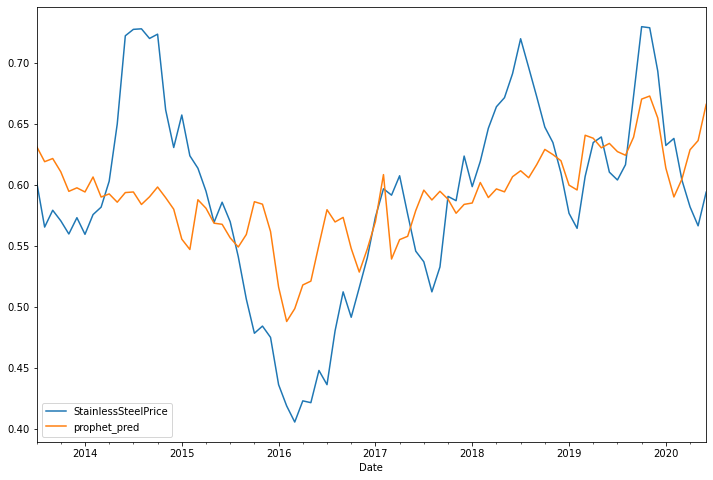

In [25]:
## let us see now
df['prophet_pred'] = prophet_pred['yhat'][:len(df)].values
df[['StainlessSteelPrice','prophet_pred']].plot(figsize=(12,8))

In [26]:
## Let us calculate the metric for some of our data points
metric_calc(df['StainlessSteelPrice'],df['prophet_pred'], model_name=None)

Mean Absolute Error: 0.05126430034606113
Mean Absolute Percentage Error: 0.08981256529566856
Mean Squared Error: 0.0040602853430688575
Root Mean Squared Error: 0.06372036835321071
R Squared: 0.36062815150154126


> MAPE value is quite low using this model but its usage remains a question as the architecture is still not clear...

<div class="alert alert-block alert-success">
<b>Success:</b> Let's move towards ML models.
</div>